In [1]:
import numpy as np
import pandas as pd

np.random.seed(27)

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

Num GPUs Available:  1
2.3.0


# Set up OpenAQ, Meteostat APIs

OpenAQ: https://openaq.org/
MeteoStat: https://meteostat.net/en

Tools
py-openaq: https://github.com/dhhagan/py-openaq
meteostat: https://dev.meteostat.net/python/

In [2]:
import openaq
# Import Meteostat library and dependencies
from meteostat import Point, Hourly, Daily

openaq = openaq.OpenAQ(version="v2")

## Get data from OpenAQ

In [3]:
class Location:
    def __init__(self, name, lat, lon):
        self.name = name
        self.lat = lat
        self.lon = lon


locations_GR = []

cities = openaq.cities(country="GR", limit=100000, df=True)["city"]

for city in cities:
    print(city)
    res = openaq.locations(city=city, df=True)[["coordinates.latitude","coordinates.longitude"]].mean()
    
    locations_GR.append(Location(city, res["coordinates.latitude"], res["coordinates.longitude"]))
    
# cities available pollutants
# ΑΤΤΙΚΗ - ['pm25','pm10','o3''so2','co'],
# ΔΥΤΙΚΗ ΕΛΛΑΔΑ - ['pm25','pm10','so2','co','no2'],
# ΘΕΣΣΑΛΙΑ - ['pm25','pm10'],
# ΚΕΝΤΡΙΚΗ ΜΑΚΕΔΟΝΙΑ - ['pm25','pm10','no2','o3''so2','co']
# ΣΤΕΡΕΑ ΕΛΛΑΔΑ - ['pm25','pm10','so2','no2','o3']

ΑΤΤΙΚΗ
ΔΥΤΙΚΗ ΕΛΛΑΔΑ
ΘΕΣΣΑΛΙΑ
ΚΕΝΤΡΙΚΗ ΜΑΚΕΔΟΝΙΑ
ΣΤΕΡΕΑ ΕΛΛΑΔΑ


In [4]:
from datetime import datetime, timedelta
import time

# We will select ΑΤΤΙΚΗ as the first location
selected_location = locations_GR[0]
print(selected_location.name)
# Format coordinates to align with OpenAQ standards
coordinates = "{},{}".format(round(selected_location.lat, 8), round(selected_location.lon, 8))

now = datetime(2021,10,1)

# For some reason the OpenAQ API accepts the date only in this way
date_from = datetime(2020 , 5, 10)
date_to = datetime(now.year, now.month, now.day) + timedelta(days=1)

print("Time Range: {} - {}".format(date_from, date_to))

selected_pollutants = ['pm25','pm10','no2','o3','so2','co']

# Create empty Dataframe
df_pollutants = pd.DataFrame(columns=selected_pollutants)

# getPollutants()

for pollutant in selected_pollutants:
    locations = openaq.locations(coordinates=coordinates, parameter=pollutant, radius=20000, df=True, has_geo=True)

    dfs_array = []
    for location in locations["id"]:
        try:
            time.sleep(3)
            df = openaq.measurements(location=location,
                                     date_from=date_from.date(), 
                                     date_to=date_to.date(),
                                     limit=100000, 
                                     parameter=pollutant,
                                     df=True,
                                     sort="asc")[["value"]].resample('H').mean()
            
            dfs_array.append(df)
            print("Added location {}".format(location))
        
        except:
            print("Skipped location {}".format(location))
    
    dfs_array = sorted(dfs_array,key=lambda x:x.index[0])
    df_pollutants[pollutant] = pd.concat(dfs_array, join="outer", axis = 1, sort=False).mean(axis=1)
    print("Added pollutant {}".format(pollutant))
    print("---------------------")

print("Data fetching completed!")

df_pollutants

ΑΤΤΙΚΗ
Time Range: 2020-05-10 00:00:00 - 2021-10-02 00:00:00
Skipped location 230760
Skipped location 69698
Skipped location 64500
Skipped location 65735
Skipped location 69696
Skipped location 69657
Skipped location 68392
Skipped location 64623
Skipped location 231382
Skipped location 224321
Skipped location 229199
Skipped location 72050
Skipped location 64605
Skipped location 71296
Skipped location 67591
Skipped location 224559
Skipped location 64611
Skipped location 63765
Skipped location 64864
Skipped location 69658
Skipped location 68378
Skipped location 64579
Skipped location 69656
Skipped location 222522
Skipped location 223303
Added location 236471
Skipped location 69655
Skipped location 69684
Skipped location 71161
Skipped location 227422
Skipped location 72049
Skipped location 73251
Skipped location 224272
Skipped location 66474
Added location 7832
Added location 7962
Added location 9514
Added location 9535
Added location 9538
Added location 9604
Added location 235579
Added l

,pm25,pm10,no2,o3,so2,co
date.local,,,,,,
2020-05-10 03:00:00,15.333333,22.800,42.800,50.833333,4.333333,800.0
2020-05-10 04:00:00,14.833333,24.600,42.900,48.000000,4.333333,650.0
2020-05-10 05:00:00,15.333333,23.200,35.800,46.500000,4.666667,600.0
2020-05-10 06:00:00,14.166667,22.900,31.700,47.833333,4.666667,500.0
2020-05-10 07:00:00,14.333333,20.700,36.000,43.500000,5.333333,550.0
...,...,...,...,...,...,...
2021-10-01 23:00:00,8.666667,19.375,19.750,71.875000,3.000000,700.0
2021-10-02 00:00:00,7.166667,18.125,15.750,76.500000,2.333333,550.0
2021-10-02 01:00:00,8.000000,18.750,16.625,76.250000,3.000000,500.0


array([<AxesSubplot:xlabel='date.local'>,
       <AxesSubplot:xlabel='date.local'>,
       <AxesSubplot:xlabel='date.local'>,
       <AxesSubplot:xlabel='date.local'>,
       <AxesSubplot:xlabel='date.local'>,
       <AxesSubplot:xlabel='date.local'>], dtype=object)

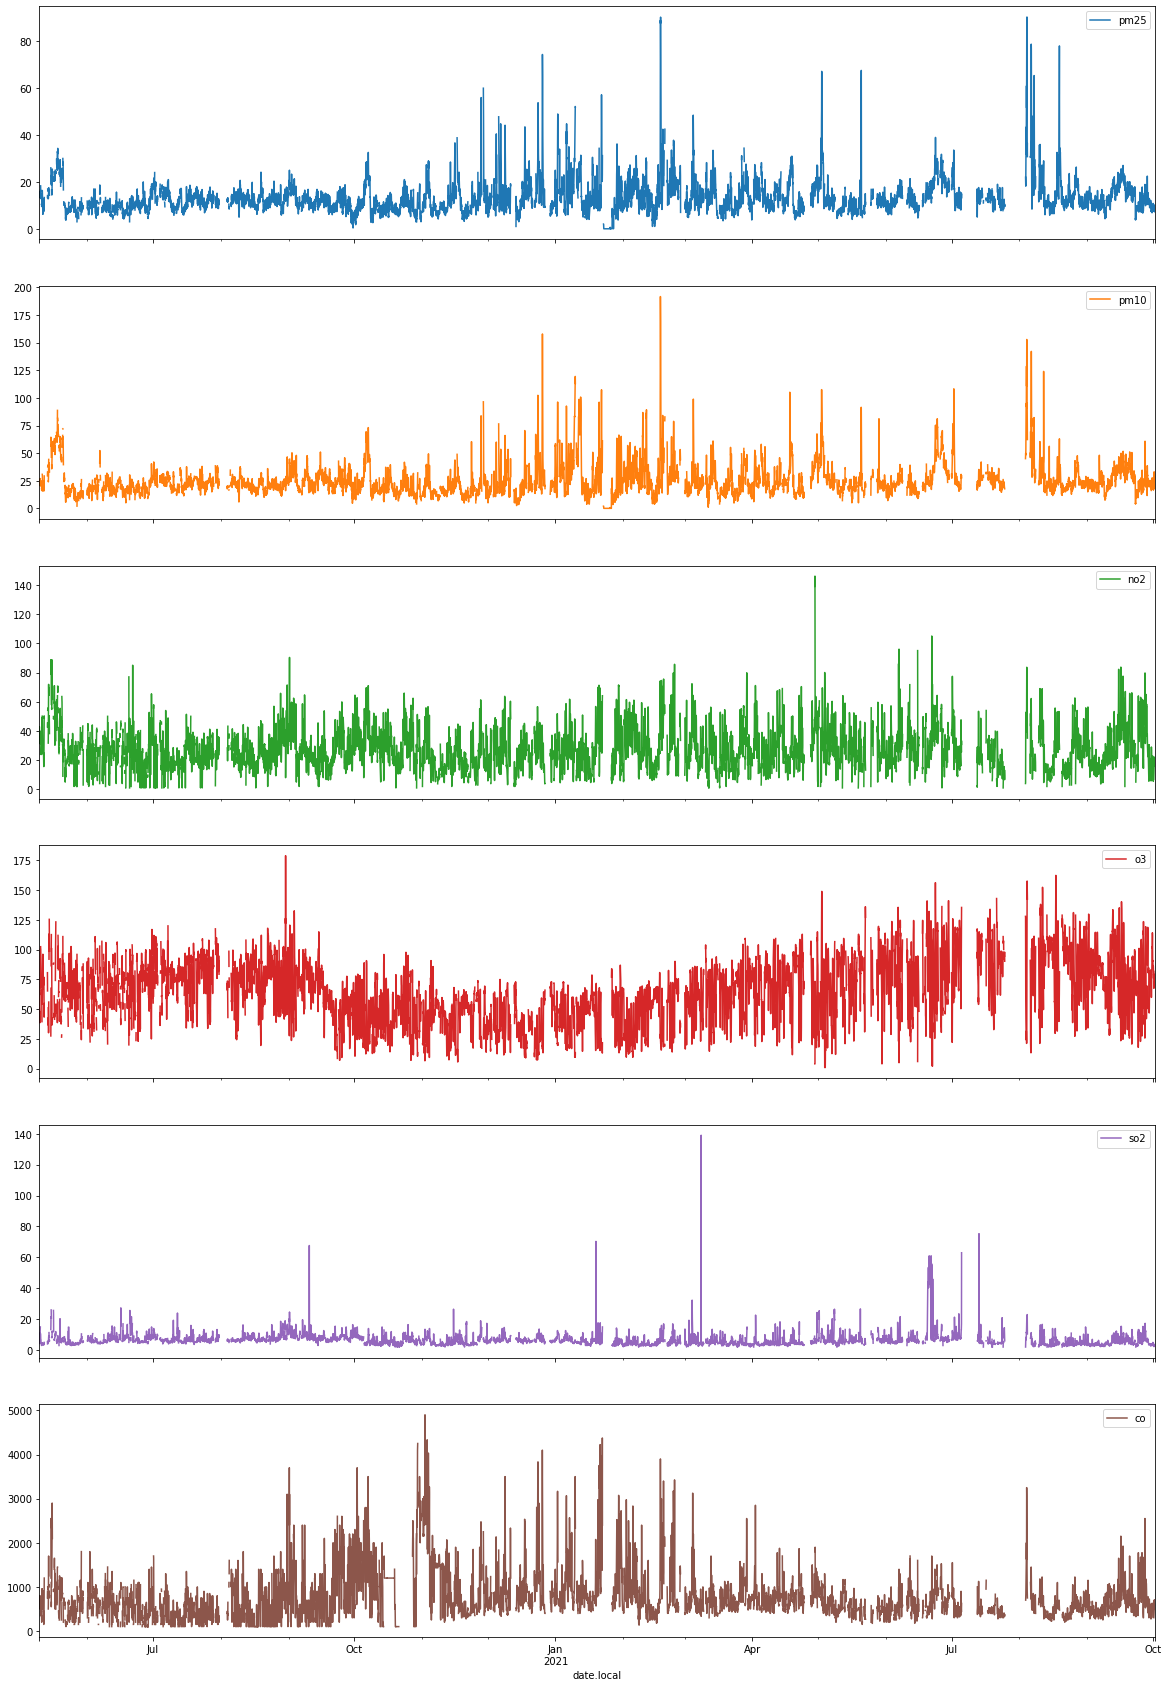

In [5]:
df_pollutants.plot(figsize=(20,30), subplots=True)

In [6]:
# Create Point for Athens
# We will give the median between the maximum: 338m, minimum: 70m elevation of Athens 

loc = Point(selected_location.lat, selected_location.lon, 204)

# temp  The air temperature in °C
# dwpt  The dew point in °C
# rhum  The relative humidity in percent (%)
# prcp  The one hour precipitation total in mm
# snow  The snow depth in mm
# wdir  The average wind direction in degrees (°)
# wspd  The average wind speed in km/h
# wpgt  The peak wind gust in km/h
# pres  The average sea-level air pressure in hPa
# tsun  The one hour sunshine total in minutes (m)
# coco  The weather condition code

# Get hourly data
df_weather = Hourly(loc=loc, start=date_from, end=date_to)
df_weather = df_weather.normalize()
df_weather = df_weather.fetch()

# Remove columns that hold no values
# 'temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'coco'
weather_features = ['dwpt', 'prcp', 'snow', 'wdir', 'wpgt', 'tsun']
df_weather.drop(weather_features, axis=1, inplace=True)
# df_weather = df_weather.interpolate(method='time')

final_df = df_pollutants.merge(df_weather, left_index=True, right_index=True)

final_df

,pm25,pm10,no2,o3,so2,co,temp,rhum,wspd,pres,coco
2020-05-10 03:00:00,15.333333,22.800000,42.80,50.833333,4.333333,800.0,12.3,65.9,4.1,1014.7,1.0
2020-05-10 04:00:00,14.833333,24.600000,42.90,48.000000,4.333333,650.0,13.7,61.9,3.1,1015.0,1.0
2020-05-10 05:00:00,15.333333,23.200000,35.80,46.500000,4.666667,600.0,15.9,55.8,2.2,1015.2,1.0
2020-05-10 06:00:00,14.166667,22.900000,31.70,47.833333,4.666667,500.0,18.9,51.4,0.0,1015.4,2.0
2020-05-10 07:00:00,14.333333,20.700000,36.00,43.500000,5.333333,550.0,19.9,45.8,2.2,1016.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01 20:00:00,9.997253,22.843162,22.00,72.000000,2.666667,650.0,18.5,53.0,22.2,1018.4,2.0
2021-10-01 21:00:00,9.020690,22.973946,20.75,72.625000,3.000000,700.0,16.9,57.0,22.2,1020.1,2.0
2021-10-01 22:00:00,8.760847,19.210288,18.25,73.000000,3.000000,550.0,16.9,57.6,21.2,1019.5,2.0
2021-10-01 23:00:00,8.666667,19.375000,19.75,71.875000,3.000000,700.0,16.8,58.1,20.2,1019.0,2.0


## Fill any empty value

In [7]:
cols_with_Nan = final_df.columns[final_df.isnull().any()].tolist()

if cols_with_Nan:
    for col in cols_with_Nan:
        while(final_df[col].isnull().sum() > 0):
            final_df[col] = final_df[col].fillna(final_df[col].rolling('4D',min_periods=1).mean())
        final_df[col] = final_df[col].interpolate(method='pchip', limit_direction='both')
        
final_df.isnull().sum()

pm25    0
pm10    0
no2     0
o3      0
so2     0
co      0
temp    0
rhum    0
wspd    0
pres    0
coco    0
dtype: int64

# Calculate AQI for each pollutant

EEA AQI TABLE

| Key | Category | PM2,5 μg/m³ | PM10 μg/m³ | NO2 ppb | O3 ppb | SO2 ppb
| :- | :- | :- | :- | :- | :- | :- |
| 1 | Good | 0-10 | 0-20 | 0-40 | 0-50 | 0-100 | 
| 2 | Fair | 10-20 | 20-40 | 40-90 | 50-100 | 100-200 | 
| 3 | Moderate | 20-25 | 40-50 | 90-120 | 100-130 | 200-350 | 
| 4 | Poor | 25-50 | 50-100 | 120-230 | 130-240 | 350-500 |
| 5 | Very Poor | 50-75 | 100-150 | 230-340 | 240-380 | 500-750 |
| 6 | Extremely Poor | 75-800 | 150-1200 | 340-1000 | 380-800 | 750-1250 |

We will use key numbers for each category:

Good: 1
Fair: 2
Moderate: 3
Poor: 4
Very Poor: 5
Extremely Poor: 6

### Define functions to calculate AQI for each pollutant

In [8]:
def calcPM25(x):
    if x <= 10:
        return 1
    elif x >=11 and x <= 20:
        return 2
    elif x >=21 and x <= 25:
        return 3
    elif x >=26 and x <= 50:
        return 4
    elif x >=51 and x <= 75:
        return 5
    elif x >=76:
        return 6
    else:
        return 1
    
def calcPM10(x):
    if x <= 20:
        return 1
    elif x >=21 and x <= 40:
        return 2
    elif x >=41 and x <= 50:
        return 3
    elif x >=51 and x <= 100:
        return 4
    elif x >=101 and x <= 150:
        return 5
    elif x >=151:
        return 6
    else:
        return 1
    
def calcNO2(x):
    if x <= 40:
        return 1
    elif x >=41 and x <= 90:
        return 2
    elif x >=91 and x <= 120:
        return 3
    elif x >=121 and x <= 230:
        return 4
    elif x >=231 and x <= 340:
        return 5
    elif x >=341:
        return 6
    else:
        return 1
    
def calcO3(x):
    if x <= 50:
        return 1
    elif x >=51 and x <= 100:
        return 2
    elif x >=101 and x <= 130:
        return 3
    elif x >=131 and x <= 240:
        return 4
    elif x >=241 and x <= 380:
        return 5
    elif x >=381:
        return 6
    else:
        return 1
    
def calcSO2(x):
    if x <= 100:
        return 1
    elif x >=101 and x <= 200:
        return 2
    elif x >=201 and x <= 350:
        return 3
    elif x >=351 and x <= 500:
        return 4
    elif x >=501 and x <= 750:
        return 5
    elif x >=751:
        return 6
    else:
        return 1
    

    
final_df["pm25_AQI"] = final_df["pm25"].apply(lambda x: calcPM25(x))
final_df["pm10_AQI"] = final_df["pm10"].apply(lambda x: calcPM10(x))
final_df["no2_AQI"] = final_df["no2"].apply(lambda x: calcNO2(x))
final_df["o3_AQI"] = final_df["o3"].apply(lambda x: calcO3(x))
final_df["so2_AQI"] = final_df["so2"].apply(lambda x: calcSO2(x))

Source: https://www.euronews.com/weather/copernicus-air-quality-index

The overall hourly European Air Quality index is simply defined as the highest value of the 5 individual pollutants indexes computed for the same hour. For instance, if the indices relative to O3, NO2, SO2, PM2.5 and PM10 are 1,3,1,2,2 respectively, the overall index will be 3.

In [9]:
# final_df["overall_AQI"] = max(final_df[["pm25_AQI", "pm10_AQI", "o3_AQI", "so2_AQI", "co_AQI"]])
final_df["overall_AQI"] = final_df[["pm25_AQI","pm10_AQI", "no2_AQI", "o3_AQI", "so2_AQI"]].max(axis=1)

final_df

,pm25,pm10,no2,o3,so2,co,temp,rhum,wspd,pres,coco,pm25_AQI,pm10_AQI,no2_AQI,o3_AQI,so2_AQI,overall_AQI
2020-05-10 03:00:00,15.333333,22.800000,42.80,50.833333,4.333333,800.0,12.3,65.9,4.1,1014.7,1.0,2,2,2,1,1,2
2020-05-10 04:00:00,14.833333,24.600000,42.90,48.000000,4.333333,650.0,13.7,61.9,3.1,1015.0,1.0,2,2,2,1,1,2
2020-05-10 05:00:00,15.333333,23.200000,35.80,46.500000,4.666667,600.0,15.9,55.8,2.2,1015.2,1.0,2,2,1,1,1,2
2020-05-10 06:00:00,14.166667,22.900000,31.70,47.833333,4.666667,500.0,18.9,51.4,0.0,1015.4,2.0,2,2,1,1,1,2
2020-05-10 07:00:00,14.333333,20.700000,36.00,43.500000,5.333333,550.0,19.9,45.8,2.2,1016.0,1.0,2,1,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01 20:00:00,9.997253,22.843162,22.00,72.000000,2.666667,650.0,18.5,53.0,22.2,1018.4,2.0,1,2,1,2,1,2
2021-10-01 21:00:00,9.020690,22.973946,20.75,72.625000,3.000000,700.0,16.9,57.0,22.2,1020.1,2.0,1,2,1,2,1,2
2021-10-01 22:00:00,8.760847,19.210288,18.25,73.000000,3.000000,550.0,16.9,57.6,21.2,1019.5,2.0,1,1,1,2,1,2
2021-10-01 23:00:00,8.666667,19.375000,19.75,71.875000,3.000000,700.0,16.8,58.1,20.2,1019.0,2.0,1,1,1,2,1,2


### Change type of each value for memory performance

In [10]:
final_df = final_df.astype(np.float32)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12238 entries, 2020-05-10 03:00:00 to 2021-10-02 00:00:00
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pm25         12238 non-null  float32
 1   pm10         12238 non-null  float32
 2   no2          12238 non-null  float32
 3   o3           12238 non-null  float32
 4   so2          12238 non-null  float32
 5   co           12238 non-null  float32
 6   temp         12238 non-null  float32
 7   rhum         12238 non-null  float32
 8   wspd         12238 non-null  float32
 9   pres         12238 non-null  float32
 10  coco         12238 non-null  float32
 11  pm25_AQI     12238 non-null  float32
 12  pm10_AQI     12238 non-null  float32
 13  no2_AQI      12238 non-null  float32
 14  o3_AQI       12238 non-null  float32
 15  so2_AQI      12238 non-null  float32
 16  overall_AQI  12238 non-null  float32
dtypes: float32(17)
memory usage: 908.3 KB


# Data Correlation

Pandas offers 3 methods of calculating correlation. Pearson, Spearman, Kendall

The Pearson's Correlation Coefficient is also known as the Pearson Product-Moment Correlation Coefficient. It is a measure of the linear relationship between two random variables - X and Y. Mathematically, if (σXY) is the covariance between X and Y, and (σX) is the standard deviation of X, then the Pearson's correlation coefficient ρ is given by:

ρxy = σxy / ( σx * σy )

## Pearson

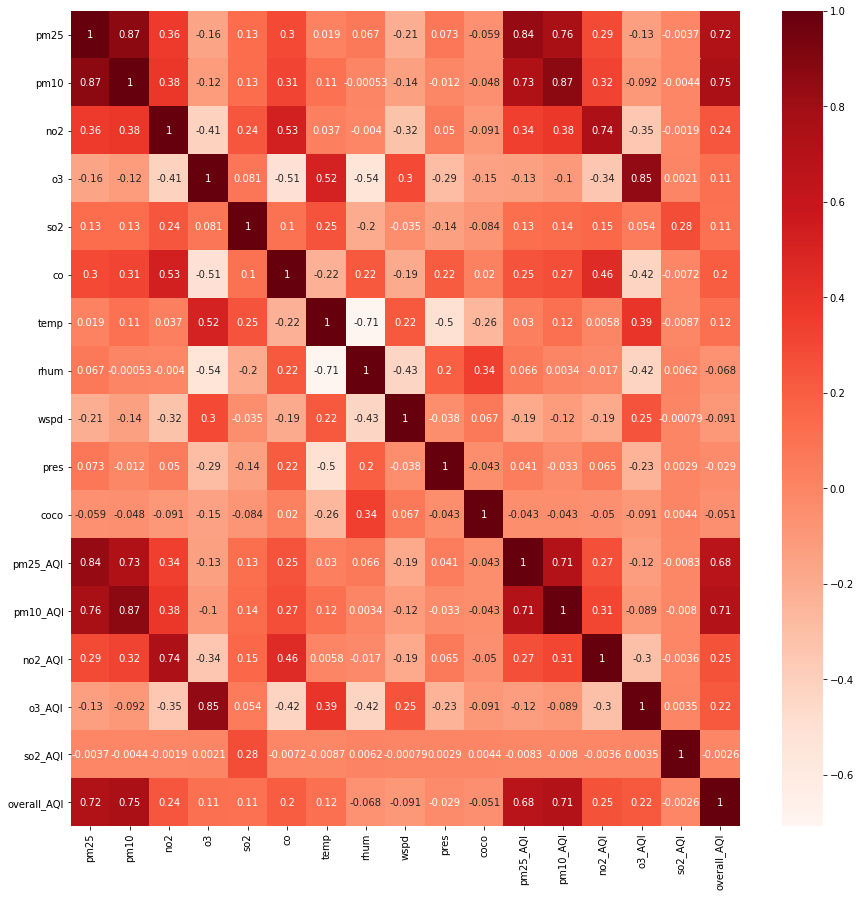

In [11]:
plt.figure(figsize=(15,15))
cor = final_df.corr(method='pearson')
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

## Spearman's rho

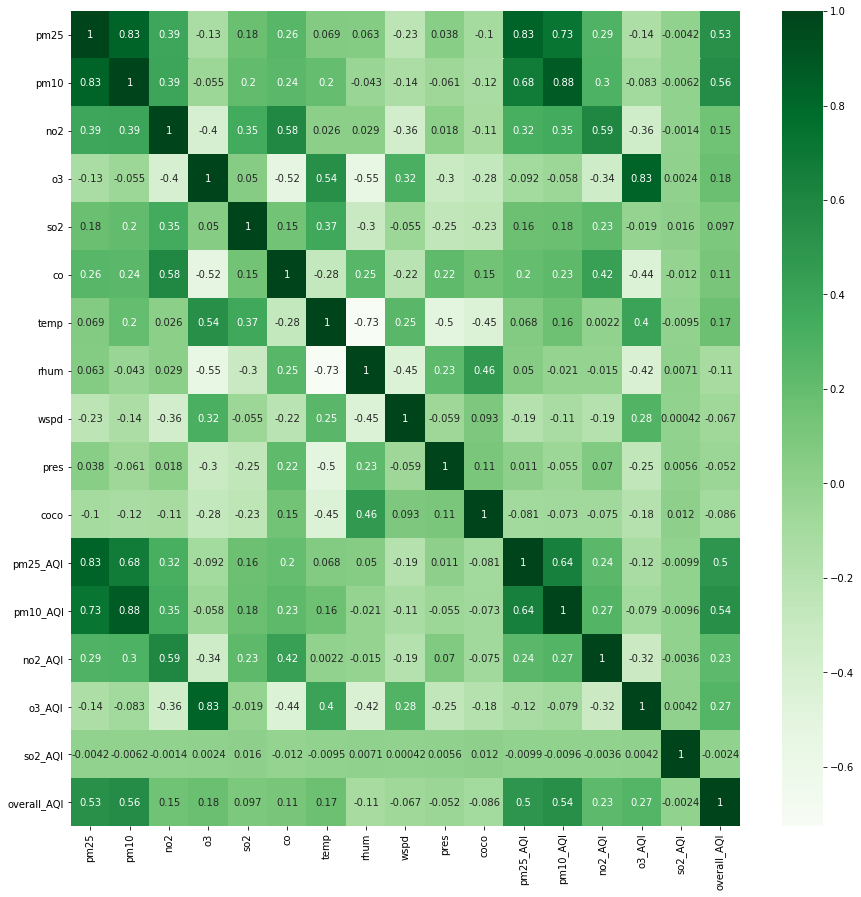

In [12]:
plt.figure(figsize=(15,15))
cor = final_df.corr(method='spearman')
sns.heatmap(cor, annot=True, cmap=plt.cm.Greens)
plt.show()

## Kendall's  tau

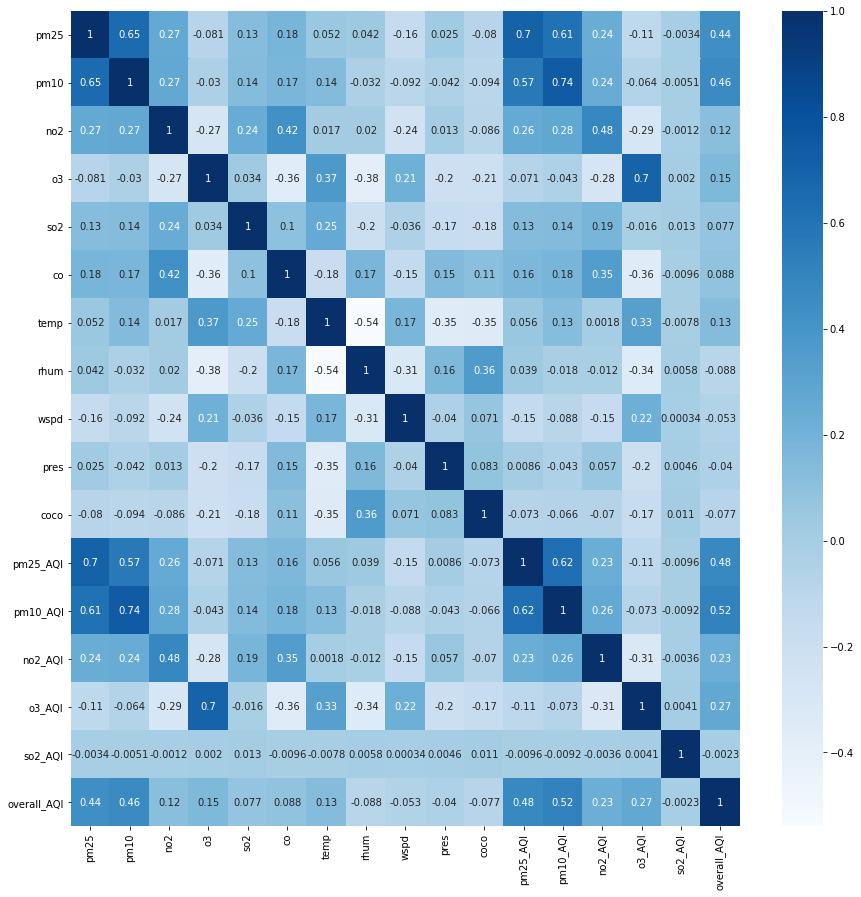

In [13]:
plt.figure(figsize=(15,15))
cor = final_df.corr(method='kendall')
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()

# Data Preparation for Machine Learning Models

In [14]:
final_df.columns

Index(['pm25', 'pm10', 'no2', 'o3', 'so2', 'co', 'temp', 'rhum', 'wspd',
       'pres', 'coco', 'pm25_AQI', 'pm10_AQI', 'no2_AQI', 'o3_AQI', 'so2_AQI',
       'overall_AQI'],
      dtype='object')

In [15]:
dataset = final_df.copy()
dataset

,pm25,pm10,no2,o3,so2,co,temp,rhum,wspd,pres,coco,pm25_AQI,pm10_AQI,no2_AQI,o3_AQI,so2_AQI,overall_AQI
2020-05-10 03:00:00,15.333333,22.799999,42.799999,50.833332,4.333333,800.0,12.300000,65.900002,4.100000,1014.700012,1.0,2.0,2.0,2.0,1.0,1.0,2.0
2020-05-10 04:00:00,14.833333,24.600000,42.900002,48.000000,4.333333,650.0,13.700000,61.900002,3.100000,1015.000000,1.0,2.0,2.0,2.0,1.0,1.0,2.0
2020-05-10 05:00:00,15.333333,23.200001,35.799999,46.500000,4.666667,600.0,15.900000,55.799999,2.200000,1015.200012,1.0,2.0,2.0,1.0,1.0,1.0,2.0
2020-05-10 06:00:00,14.166667,22.900000,31.700001,47.833332,4.666667,500.0,18.900000,51.400002,0.000000,1015.400024,2.0,2.0,2.0,1.0,1.0,1.0,2.0
2020-05-10 07:00:00,14.333333,20.700001,36.000000,43.500000,5.333333,550.0,19.900000,45.799999,2.200000,1016.000000,1.0,2.0,1.0,1.0,1.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01 20:00:00,9.997252,22.843163,22.000000,72.000000,2.666667,650.0,18.500000,53.000000,22.200001,1018.400024,2.0,1.0,2.0,1.0,2.0,1.0,2.0
2021-10-01 21:00:00,9.020690,22.973946,20.750000,72.625000,3.000000,700.0,16.900000,57.000000,22.200001,1020.099976,2.0,1.0,2.0,1.0,2.0,1.0,2.0
2021-10-01 22:00:00,8.760846,19.210289,18.250000,73.000000,3.000000,550.0,16.900000,57.599998,21.200001,1019.500000,2.0,1.0,1.0,1.0,2.0,1.0,2.0
2021-10-01 23:00:00,8.666667,19.375000,19.750000,71.875000,3.000000,700.0,16.799999,58.099998,20.200001,1019.000000,2.0,1.0,1.0,1.0,2.0,1.0,2.0


### Split data

In [16]:
from sklearn.model_selection import train_test_split

# ["pm25","pm10","no2","o3","so2","co","temp","rhum","wspd","pres","pm25_AQI","pm10_AQI","no2_AQI","o3_AQI","so2_AQI","overall_AQI", "row_index"]

features=dataset.values
targets=dataset[["pm25", "pm10", "no2", "o3", "so2"]].values

X_train, X_test, y_train, y_test  = train_test_split(features, targets, test_size=0.1, random_state=1, shuffle=False)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.1, random_state=1, shuffle=False)

print("features:", features.shape)
print("targets:", targets.shape)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("X_val:", X_val.shape)

print("y_train:", y_train.shape)
print("y_test:", y_test.shape)
print("y_val:", y_val.shape)

features: (12238, 17)
targets: (12238, 5)
X_train: (9912, 17)
X_test: (1224, 17)
X_val: (1102, 17)
y_train: (9912, 5)
y_test: (1224, 5)
y_val: (1102, 5)


### Data Normalizaton

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)

X_val = scaler.transform(X_val)

X_test = scaler.transform(X_test)

X_train.shape, X_test.shape

((9912, 17), (1224, 17))

### Set up data with TimeseriesGenerator

In [57]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

win_length=12
batch_size=4
num_features=features.shape[1]

train_generator = TimeseriesGenerator(X_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

# Create LSTM model

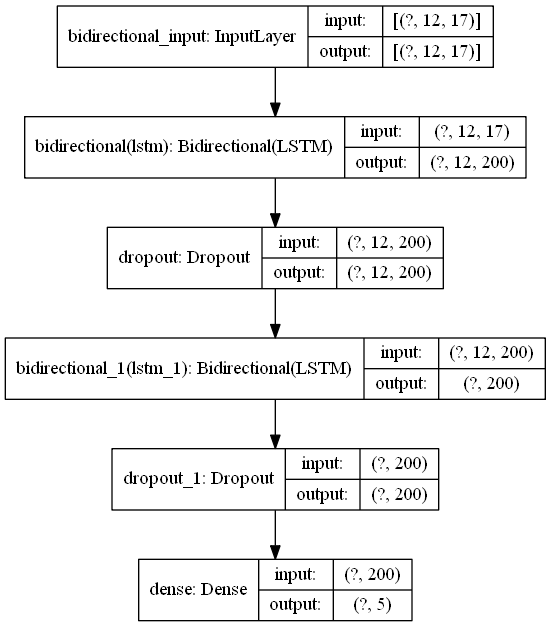

In [19]:
model_LSTM = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100,  return_sequences=True), input_shape=(win_length, num_features)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=False)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(targets.shape[1])
])

model_LSTM.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), loss=tf.losses.MeanSquaredLogarithmicError())

tf.keras.utils.plot_model(model=model_LSTM, show_shapes=True)

### Fit model

In [20]:
lr_monitor = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, cooldown=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)

with tf.device('/GPU:0'):
    prepared_model = model_LSTM.fit(train_generator, 
                                    validation_data=val_generator,
                                    epochs=200, 
                                    shuffle=False,  
                                    callbacks=[lr_monitor, early_stopping])

Epoch 1/200
2475/2475 [==============================] - 36s 14ms/step - loss: 0.3807 - val_loss: 0.2406
Epoch 2/200
2475/2475 [==============================] - 34s 14ms/step - loss: 0.7039 - val_loss: 0.2454
Epoch 3/200
2475/2475 [==============================] - 34s 14ms/step - loss: 0.1875 - val_loss: 0.2426
Epoch 4/200
2475/2475 [==============================] - 34s 14ms/step - loss: 0.1725 - val_loss: 0.2035
Epoch 5/200
2475/2475 [==============================] - 34s 14ms/step - loss: 0.1451 - val_loss: 0.1785
Epoch 6/200
2475/2475 [==============================] - 34s 14ms/step - loss: 0.1206 - val_loss: 0.1777
Epoch 7/200
2475/2475 [==============================] - 34s 14ms/step - loss: 0.1113 - val_loss: 0.1755
Epoch 8/200
2475/2475 [==============================] - 33s 14ms/step - loss: 0.1012 - val_loss: 0.1480
Epoch 9/200
2475/2475 [==============================] - 32s 13ms/step - loss: 0.0934 - val_loss: 0.1309
Epoch 10/200
2475/2475 [==============================]

Text(0, 0.5, 'mse score')

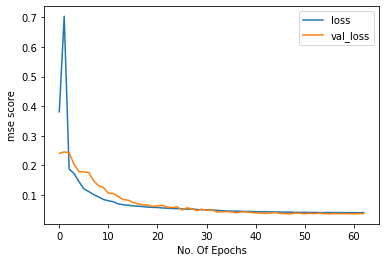

In [21]:
plt.plot(prepared_model.history["loss"],label="loss")
plt.plot(prepared_model.history["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("No. Of Epochs")
plt.ylabel("mse score")

In [22]:
model_LSTM.evaluate(test_generator, verbose=1)

303/303 [==============================] - 1s 4ms/step - loss: 0.0351


0.03514399379491806

### Get Predictions for new cases

In [23]:
predictions=model_LSTM.predict(test_generator)

pd.DataFrame(predictions)

,0,1,2,3,4
0,15.131695,35.218933,15.829409,88.361229,4.729753
1,12.857466,29.606752,15.047464,93.369713,5.169001
2,13.322355,30.234695,15.664080,96.667007,4.999668
3,12.353285,28.158108,14.618301,96.564369,4.705721
4,9.216188,23.216320,12.694891,93.836601,4.598744
...,...,...,...,...,...
1207,10.108660,21.613592,19.511742,73.700096,4.150776
1208,9.849548,21.044538,19.226679,75.274223,4.202506
1209,9.454805,20.531403,17.339375,77.635101,4.205993
1210,8.961014,17.919228,15.391253,77.595207,4.092032


In [24]:
df_pred=pd.DataFrame(X_test[:,:][win_length:])

rev_trans=scaler.inverse_transform(df_pred)

df_final=dataset[rev_trans.shape[0]*-1:]
df_final

,pm25,pm10,no2,o3,so2,co,temp,rhum,wspd,pres,coco,pm25_AQI,pm10_AQI,no2_AQI,o3_AQI,so2_AQI,overall_AQI
2021-08-12 13:00:00,14.000000,27.200001,15.10,101.333336,4.000000,425.0,32.099998,30.100000,25.799999,1013.900024,2.0,2.0,2.0,1.0,3.0,1.0,3.0
2021-08-12 14:00:00,13.200000,31.600000,14.30,104.777779,3.666667,425.0,31.600000,30.200001,25.799999,1013.700012,2.0,2.0,2.0,1.0,3.0,1.0,3.0
2021-08-12 15:00:00,12.000000,29.900000,13.40,101.333336,3.000000,350.0,32.099998,27.000000,25.900000,1014.700012,2.0,2.0,2.0,1.0,3.0,1.0,3.0
2021-08-12 16:00:00,8.400000,22.500000,13.00,99.444443,3.333333,350.0,30.799999,30.200001,22.100000,1014.599976,1.0,1.0,2.0,1.0,2.0,1.0,2.0
2021-08-12 17:00:00,6.000000,18.799999,11.40,98.666664,3.000000,300.0,29.700001,33.200001,17.000000,1014.400024,1.0,1.0,1.0,1.0,2.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01 20:00:00,9.997252,22.843163,22.00,72.000000,2.666667,650.0,18.500000,53.000000,22.200001,1018.400024,2.0,1.0,2.0,1.0,2.0,1.0,2.0
2021-10-01 21:00:00,9.020690,22.973946,20.75,72.625000,3.000000,700.0,16.900000,57.000000,22.200001,1020.099976,2.0,1.0,2.0,1.0,2.0,1.0,2.0
2021-10-01 22:00:00,8.760846,19.210289,18.25,73.000000,3.000000,550.0,16.900000,57.599998,21.200001,1019.500000,2.0,1.0,1.0,1.0,2.0,1.0,2.0
2021-10-01 23:00:00,8.666667,19.375000,19.75,71.875000,3.000000,700.0,16.799999,58.099998,20.200001,1019.000000,2.0,1.0,1.0,1.0,2.0,1.0,2.0


In [25]:
df_final[["pm25_pred", "pm10_pred", "no2_pred", "o3_pred", "so2_pred"]]=predictions
df_final

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,pm25,pm10,no2,o3,so2,co,temp,rhum,wspd,pres,...,pm10_AQI,no2_AQI,o3_AQI,so2_AQI,overall_AQI,pm25_pred,pm10_pred,no2_pred,o3_pred,so2_pred
2021-08-12 13:00:00,14.000000,27.200001,15.10,101.333336,4.000000,425.0,32.099998,30.100000,25.799999,1013.900024,...,2.0,1.0,3.0,1.0,3.0,15.131695,35.218933,15.829409,88.361229,4.729753
2021-08-12 14:00:00,13.200000,31.600000,14.30,104.777779,3.666667,425.0,31.600000,30.200001,25.799999,1013.700012,...,2.0,1.0,3.0,1.0,3.0,12.857466,29.606752,15.047464,93.369713,5.169001
2021-08-12 15:00:00,12.000000,29.900000,13.40,101.333336,3.000000,350.0,32.099998,27.000000,25.900000,1014.700012,...,2.0,1.0,3.0,1.0,3.0,13.322355,30.234695,15.664080,96.667007,4.999668
2021-08-12 16:00:00,8.400000,22.500000,13.00,99.444443,3.333333,350.0,30.799999,30.200001,22.100000,1014.599976,...,2.0,1.0,2.0,1.0,2.0,12.353285,28.158108,14.618301,96.564369,4.705721
2021-08-12 17:00:00,6.000000,18.799999,11.40,98.666664,3.000000,300.0,29.700001,33.200001,17.000000,1014.400024,...,1.0,1.0,2.0,1.0,2.0,9.216188,23.216320,12.694891,93.836601,4.598744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01 20:00:00,9.997252,22.843163,22.00,72.000000,2.666667,650.0,18.500000,53.000000,22.200001,1018.400024,...,2.0,1.0,2.0,1.0,2.0,10.108660,21.613592,19.511742,73.700096,4.150776
2021-10-01 21:00:00,9.020690,22.973946,20.75,72.625000,3.000000,700.0,16.900000,57.000000,22.200001,1020.099976,...,2.0,1.0,2.0,1.0,2.0,9.849548,21.044538,19.226679,75.274223,4.202506
2021-10-01 22:00:00,8.760846,19.210289,18.25,73.000000,3.000000,550.0,16.900000,57.599998,21.200001,1019.500000,...,1.0,1.0,2.0,1.0,2.0,9.454805,20.531403,17.339375,77.635101,4.205993
2021-10-01 23:00:00,8.666667,19.375000,19.75,71.875000,3.000000,700.0,16.799999,58.099998,20.200001,1019.000000,...,1.0,1.0,2.0,1.0,2.0,8.961014,17.919228,15.391253,77.595207,4.092032


<AxesSubplot:>

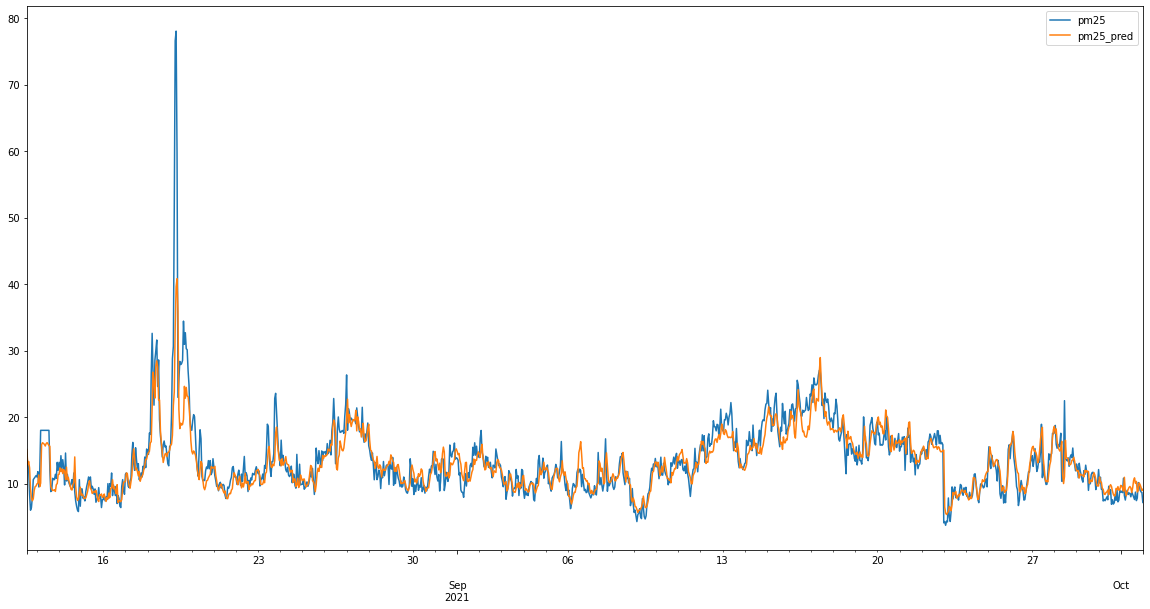

In [26]:
df_final[["pm25","pm25_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

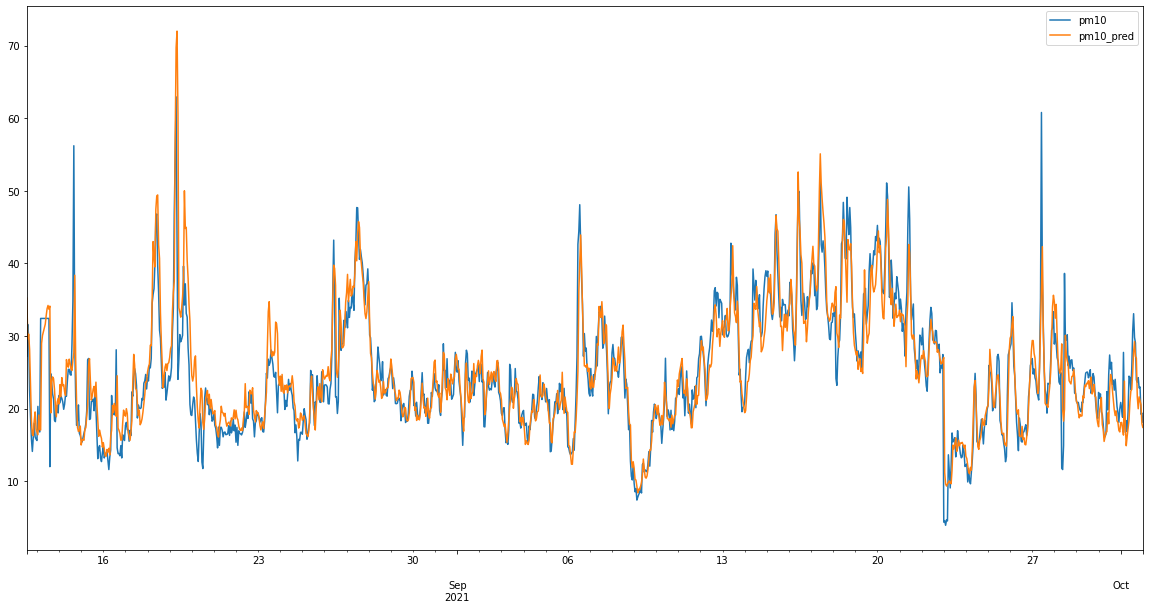

In [27]:
df_final[["pm10","pm10_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

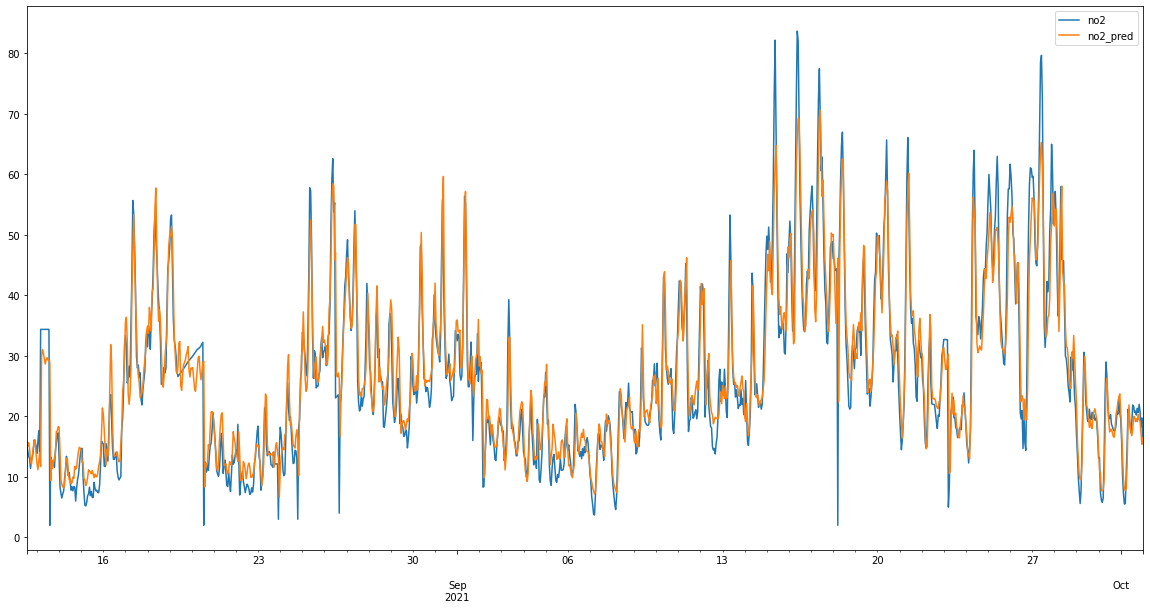

In [28]:
df_final[["no2","no2_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

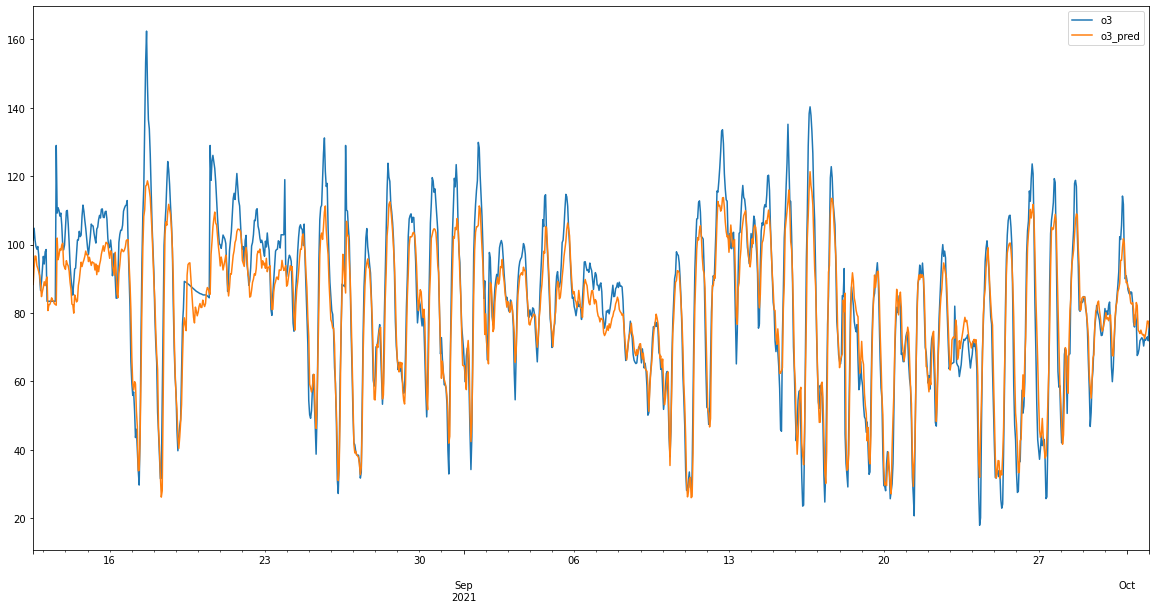

In [29]:
df_final[["o3","o3_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

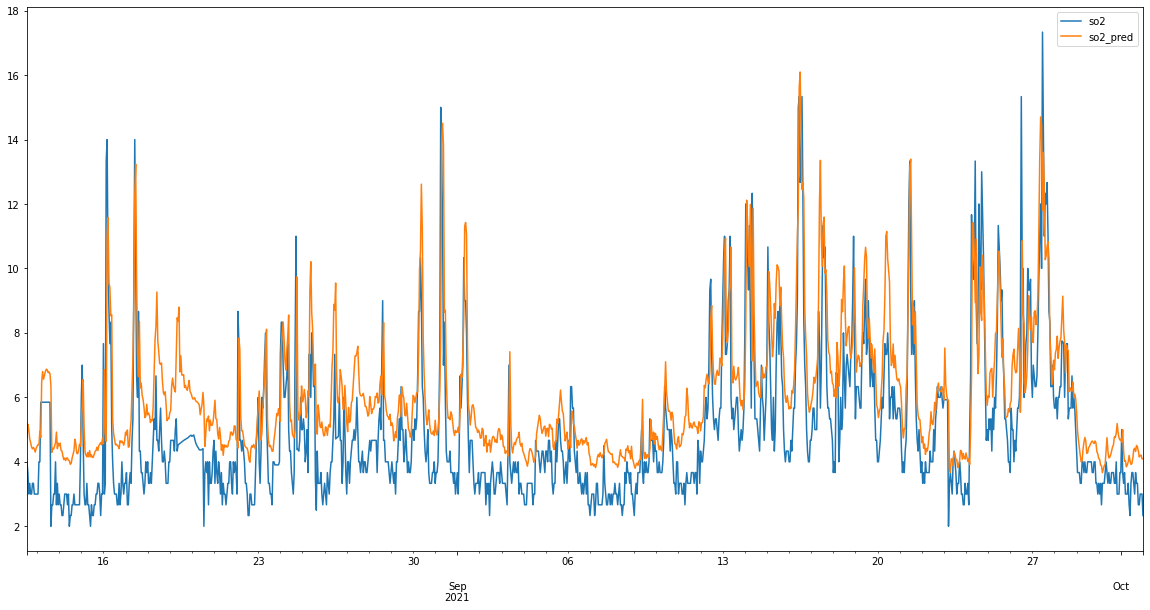

In [30]:
df_final[["so2","so2_pred"]].plot(figsize=(20,10))

# Create CNN Model

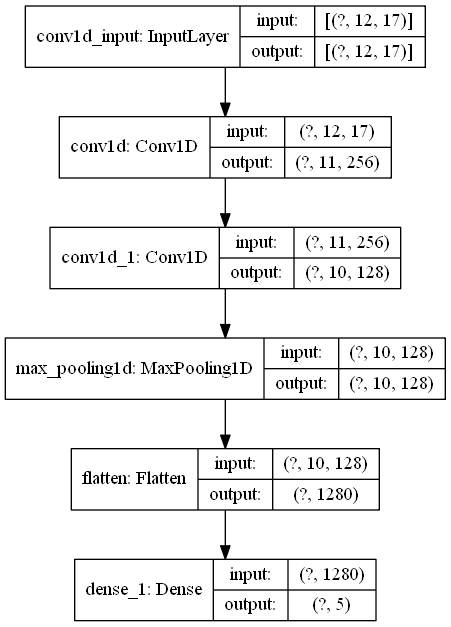

In [31]:
model_CNN = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=256, kernel_size=2, activation=tf.keras.layers.LeakyReLU(alpha=0.3), input_shape=(win_length, num_features)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=2, activation=tf.keras.layers.LeakyReLU(alpha=0.3)),
    tf.keras.layers.MaxPooling1D(pool_size=1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(targets.shape[1])
])

model_CNN.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),loss=tf.losses.MeanSquaredLogarithmicError())

tf.keras.utils.plot_model(model=model_CNN, show_shapes=True)

### Fit model

In [32]:
lr_monitor = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, cooldown=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)

with tf.device('/GPU:0'):
    prepared_model_CNN = model_CNN.fit(train_generator, 
                                       validation_data=val_generator,
                                       epochs=400, 
                                       shuffle=False,  
                                       callbacks=[lr_monitor, early_stopping])

Epoch 1/400
2475/2475 [==============================] - 10s 4ms/step - loss: 2.6870 - val_loss: 0.1665
Epoch 2/400
2475/2475 [==============================] - 10s 4ms/step - loss: 0.0890 - val_loss: 0.1114
Epoch 3/400
2475/2475 [==============================] - 10s 4ms/step - loss: 0.0734 - val_loss: 0.0911
Epoch 4/400
2475/2475 [==============================] - 10s 4ms/step - loss: 0.0695 - val_loss: 0.0838
Epoch 5/400
2475/2475 [==============================] - 10s 4ms/step - loss: 0.0636 - val_loss: 0.0825
Epoch 6/400
2475/2475 [==============================] - 10s 4ms/step - loss: 0.0578 - val_loss: 0.0729
Epoch 7/400
2475/2475 [==============================] - 10s 4ms/step - loss: 0.0571 - val_loss: 0.0723
Epoch 8/400
2475/2475 [==============================] - 10s 4ms/step - loss: 0.0536 - val_loss: 0.0665
Epoch 9/400
2475/2475 [==============================] - 10s 4ms/step - loss: 0.0515 - val_loss: 0.0683
Epoch 10/400
2475/2475 [==============================] - 10s 4m

2475/2475 [==============================] - 10s 4ms/step - loss: 0.0314 - val_loss: 0.0295
Epoch 80/400
2475/2475 [==============================] - 10s 4ms/step - loss: 0.0314 - val_loss: 0.0295
Epoch 81/400
2475/2475 [==============================] - 10s 4ms/step - loss: 0.0314 - val_loss: 0.0295
Epoch 82/400
2475/2475 [==============================] - 10s 4ms/step - loss: 0.0314 - val_loss: 0.0295
Epoch 83/400
2475/2475 [==============================] - 10s 4ms/step - loss: 0.0314 - val_loss: 0.0295
Epoch 84/400
2475/2475 [==============================] - 10s 4ms/step - loss: 0.0314 - val_loss: 0.0295
Epoch 85/400
2475/2475 [==============================] - 10s 4ms/step - loss: 0.0314 - val_loss: 0.0295
Epoch 86/400
2475/2475 [==============================] - 10s 4ms/step - loss: 0.0314 - val_loss: 0.0295
Epoch 87/400
2475/2475 [==============================] - 9s 4ms/step - loss: 0.0314 - val_loss: 0.0295
Epoch 88/400
2475/2475 [==============================] - 9s 4ms/step

Text(0, 0.5, 'mse score')

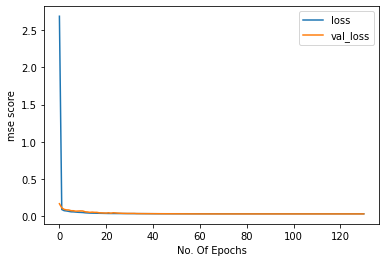

In [33]:
plt.plot(prepared_model_CNN.history["loss"],label="loss")
plt.plot(prepared_model_CNN.history["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("No. Of Epochs")
plt.ylabel("mse score")

In [34]:
model_CNN.evaluate(test_generator, verbose=1)

303/303 [==============================] - 1s 2ms/step - loss: 0.0269


0.026919471099972725

### Get Predictions for new cases

In [35]:
predictions=model_CNN.predict(test_generator)

pd.DataFrame(predictions)

,0,1,2,3,4
0,16.420115,32.538208,16.923523,90.806686,4.168096
1,13.955603,28.085703,15.374628,98.579437,5.402761
2,13.301522,29.682577,15.390564,105.167511,4.975600
3,11.445895,28.075472,16.311434,103.014893,4.248913
4,8.173141,23.078405,15.685050,98.134605,4.059108
...,...,...,...,...,...
1207,10.043941,23.906034,18.178061,69.574860,3.577384
1208,9.826425,22.817270,19.669140,68.893402,3.209980
1209,9.260560,21.961887,17.940048,71.845482,3.337845
1210,8.698309,18.453739,15.679155,72.057617,3.556707


In [36]:
df_pred=pd.DataFrame(X_test[:,:][win_length:])

rev_trans=scaler.inverse_transform(df_pred)

df_final=dataset[rev_trans.shape[0]*-1:]
df_final

,pm25,pm10,no2,o3,so2,co,temp,rhum,wspd,pres,coco,pm25_AQI,pm10_AQI,no2_AQI,o3_AQI,so2_AQI,overall_AQI
2021-08-12 13:00:00,14.000000,27.200001,15.10,101.333336,4.000000,425.0,32.099998,30.100000,25.799999,1013.900024,2.0,2.0,2.0,1.0,3.0,1.0,3.0
2021-08-12 14:00:00,13.200000,31.600000,14.30,104.777779,3.666667,425.0,31.600000,30.200001,25.799999,1013.700012,2.0,2.0,2.0,1.0,3.0,1.0,3.0
2021-08-12 15:00:00,12.000000,29.900000,13.40,101.333336,3.000000,350.0,32.099998,27.000000,25.900000,1014.700012,2.0,2.0,2.0,1.0,3.0,1.0,3.0
2021-08-12 16:00:00,8.400000,22.500000,13.00,99.444443,3.333333,350.0,30.799999,30.200001,22.100000,1014.599976,1.0,1.0,2.0,1.0,2.0,1.0,2.0
2021-08-12 17:00:00,6.000000,18.799999,11.40,98.666664,3.000000,300.0,29.700001,33.200001,17.000000,1014.400024,1.0,1.0,1.0,1.0,2.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01 20:00:00,9.997252,22.843163,22.00,72.000000,2.666667,650.0,18.500000,53.000000,22.200001,1018.400024,2.0,1.0,2.0,1.0,2.0,1.0,2.0
2021-10-01 21:00:00,9.020690,22.973946,20.75,72.625000,3.000000,700.0,16.900000,57.000000,22.200001,1020.099976,2.0,1.0,2.0,1.0,2.0,1.0,2.0
2021-10-01 22:00:00,8.760846,19.210289,18.25,73.000000,3.000000,550.0,16.900000,57.599998,21.200001,1019.500000,2.0,1.0,1.0,1.0,2.0,1.0,2.0
2021-10-01 23:00:00,8.666667,19.375000,19.75,71.875000,3.000000,700.0,16.799999,58.099998,20.200001,1019.000000,2.0,1.0,1.0,1.0,2.0,1.0,2.0


In [37]:
df_final[["pm25_pred", "pm10_pred", "no2_pred", "o3_pred", "so2_pred"]]=predictions
df_final

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,pm25,pm10,no2,o3,so2,co,temp,rhum,wspd,pres,...,pm10_AQI,no2_AQI,o3_AQI,so2_AQI,overall_AQI,pm25_pred,pm10_pred,no2_pred,o3_pred,so2_pred
2021-08-12 13:00:00,14.000000,27.200001,15.10,101.333336,4.000000,425.0,32.099998,30.100000,25.799999,1013.900024,...,2.0,1.0,3.0,1.0,3.0,16.420115,32.538208,16.923523,90.806686,4.168096
2021-08-12 14:00:00,13.200000,31.600000,14.30,104.777779,3.666667,425.0,31.600000,30.200001,25.799999,1013.700012,...,2.0,1.0,3.0,1.0,3.0,13.955603,28.085703,15.374628,98.579437,5.402761
2021-08-12 15:00:00,12.000000,29.900000,13.40,101.333336,3.000000,350.0,32.099998,27.000000,25.900000,1014.700012,...,2.0,1.0,3.0,1.0,3.0,13.301522,29.682577,15.390564,105.167511,4.975600
2021-08-12 16:00:00,8.400000,22.500000,13.00,99.444443,3.333333,350.0,30.799999,30.200001,22.100000,1014.599976,...,2.0,1.0,2.0,1.0,2.0,11.445895,28.075472,16.311434,103.014893,4.248913
2021-08-12 17:00:00,6.000000,18.799999,11.40,98.666664,3.000000,300.0,29.700001,33.200001,17.000000,1014.400024,...,1.0,1.0,2.0,1.0,2.0,8.173141,23.078405,15.685050,98.134605,4.059108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01 20:00:00,9.997252,22.843163,22.00,72.000000,2.666667,650.0,18.500000,53.000000,22.200001,1018.400024,...,2.0,1.0,2.0,1.0,2.0,10.043941,23.906034,18.178061,69.574860,3.577384
2021-10-01 21:00:00,9.020690,22.973946,20.75,72.625000,3.000000,700.0,16.900000,57.000000,22.200001,1020.099976,...,2.0,1.0,2.0,1.0,2.0,9.826425,22.817270,19.669140,68.893402,3.209980
2021-10-01 22:00:00,8.760846,19.210289,18.25,73.000000,3.000000,550.0,16.900000,57.599998,21.200001,1019.500000,...,1.0,1.0,2.0,1.0,2.0,9.260560,21.961887,17.940048,71.845482,3.337845
2021-10-01 23:00:00,8.666667,19.375000,19.75,71.875000,3.000000,700.0,16.799999,58.099998,20.200001,1019.000000,...,1.0,1.0,2.0,1.0,2.0,8.698309,18.453739,15.679155,72.057617,3.556707


<AxesSubplot:>

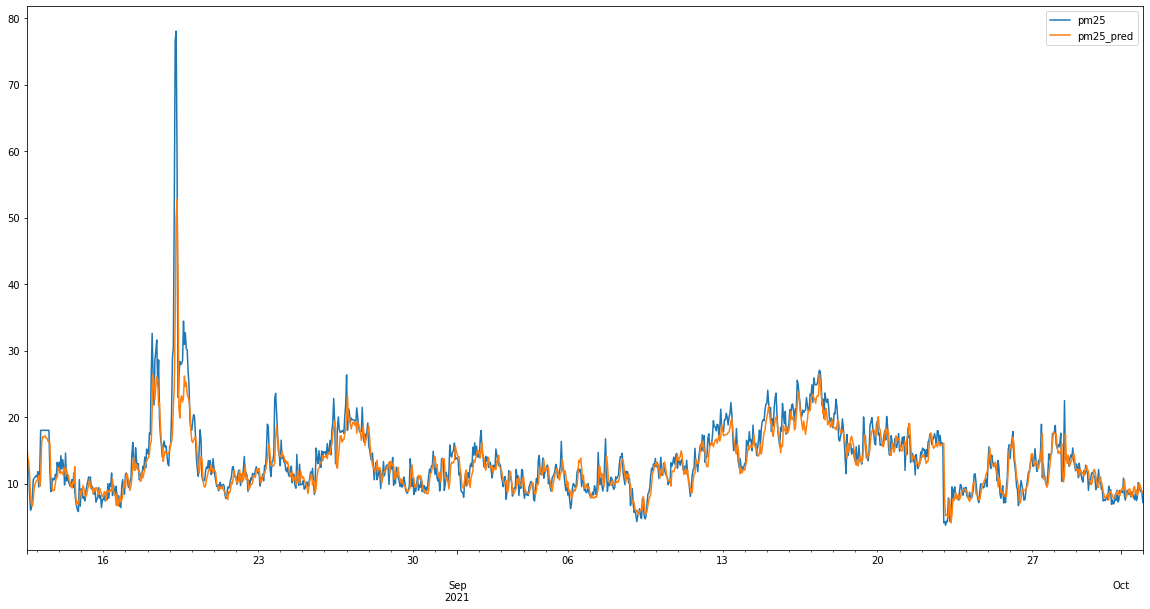

In [38]:
df_final[["pm25","pm25_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

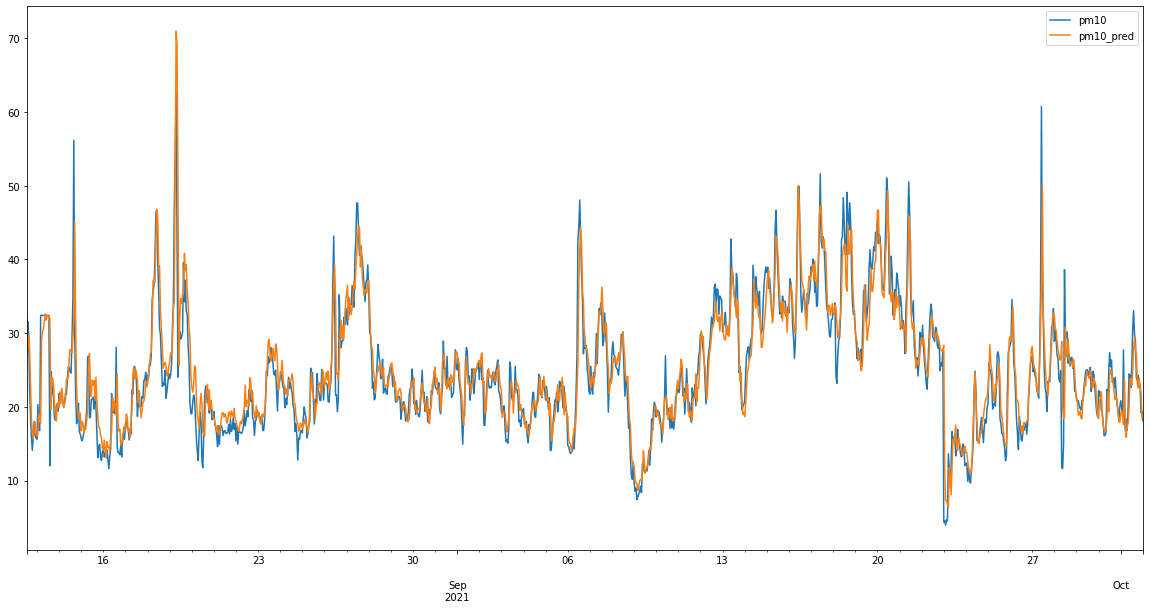

In [39]:
df_final[["pm10","pm10_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

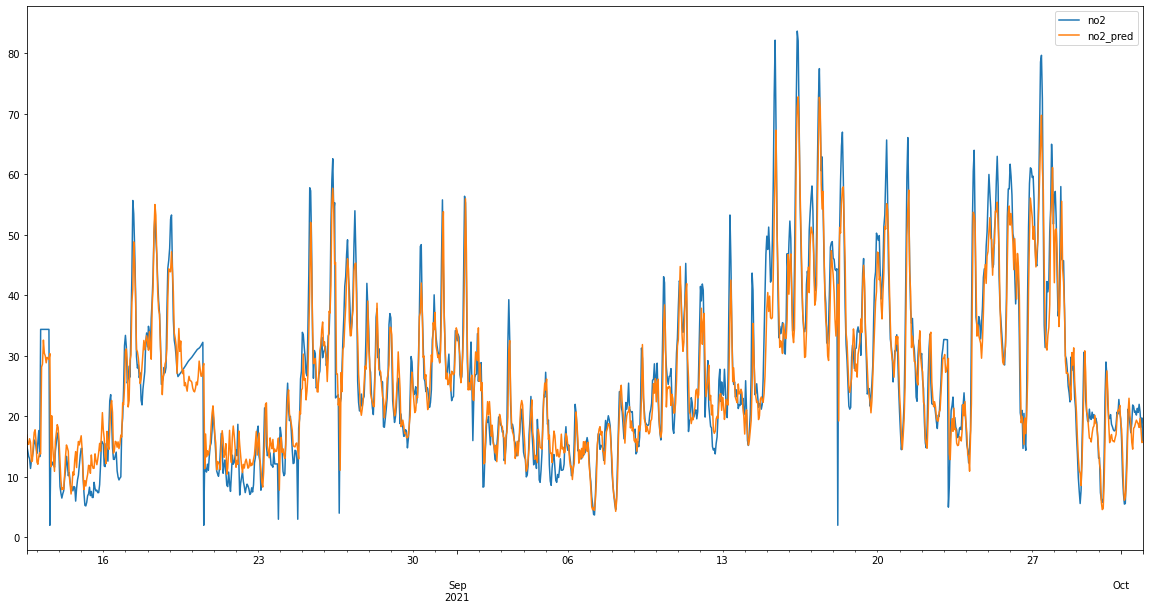

In [40]:
df_final[["no2","no2_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

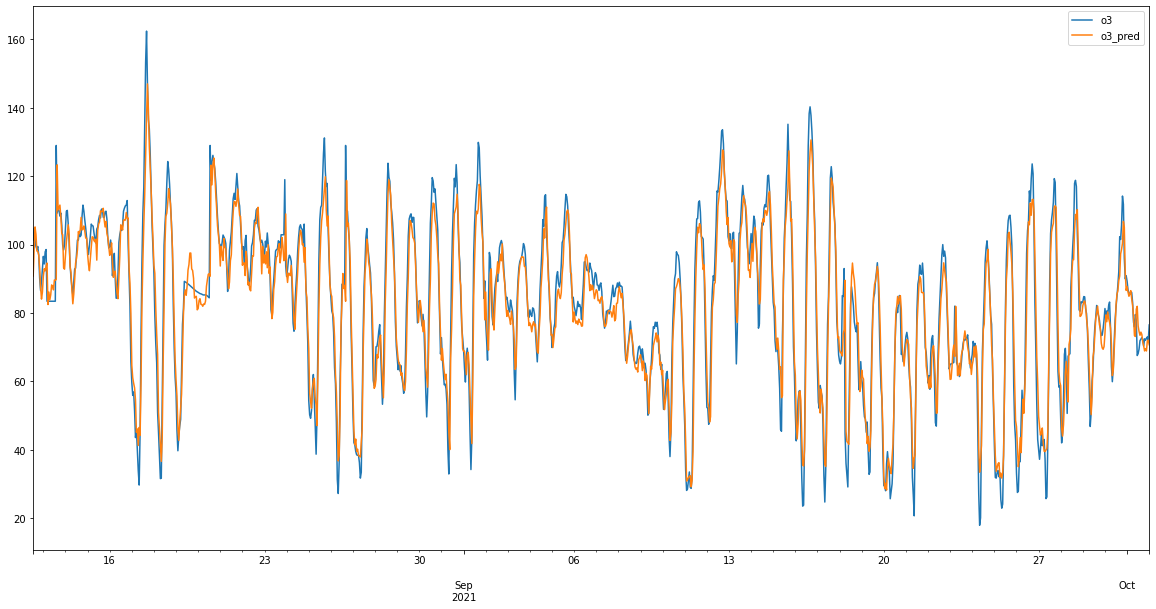

In [41]:
df_final[["o3","o3_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

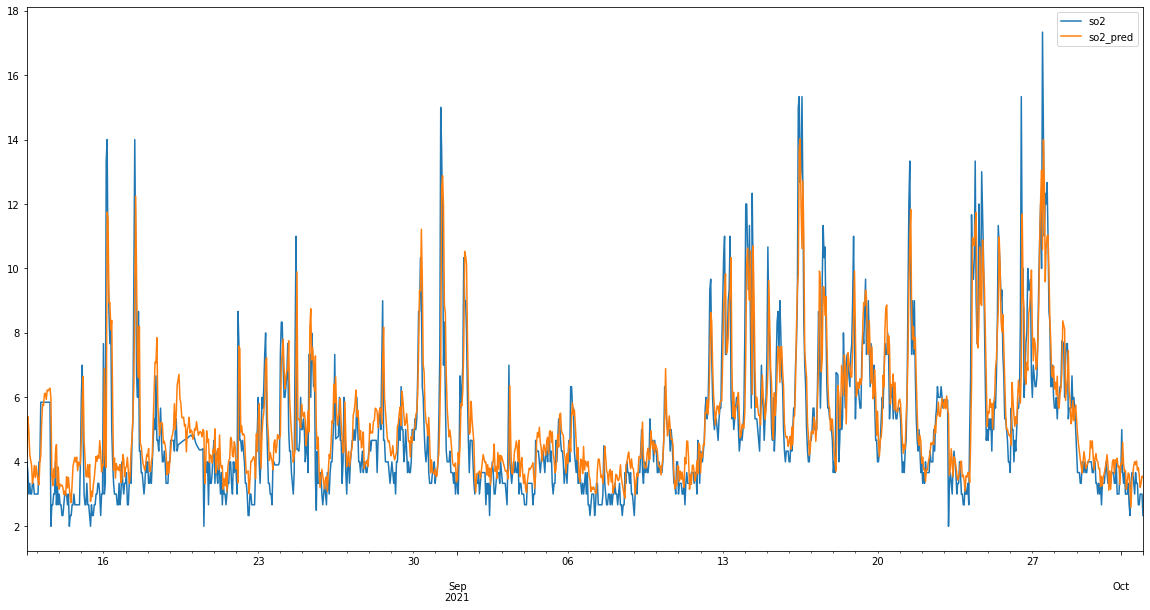

In [42]:
df_final[["so2","so2_pred"]].plot(figsize=(20,10))

# Create LSTM-CNN Model

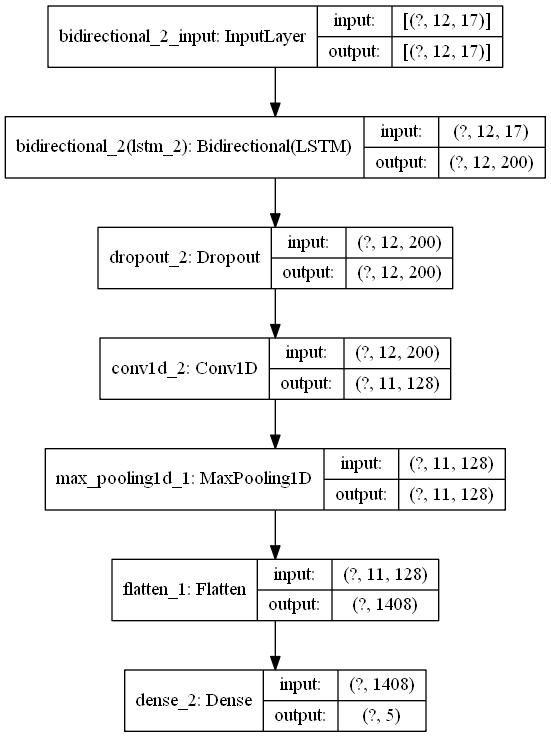

In [43]:
model_CNNLSTM = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True), input_shape=(win_length, num_features)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(filters=128, kernel_size=2, activation=tf.keras.layers.LeakyReLU(alpha=0.7)),
    tf.keras.layers.MaxPooling1D(pool_size=1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(targets.shape[1])
])

model_CNNLSTM.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),loss=tf.losses.MeanSquaredLogarithmicError())

tf.keras.utils.plot_model(model=model_CNNLSTM, show_shapes=True)

In [44]:
model_CNNLSTM.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 12, 200)           94400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 200)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 11, 128)           51328     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 11, 128)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1408)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 7045      
Total params: 152,773
Trainable params: 152,773
Non-trainable params: 0
________________________________________________

In [45]:
lr_monitor = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, cooldown=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)

with tf.device('/GPU:0'):
    prepared_model_CNNLSTM = model_CNNLSTM.fit(train_generator, 
                                       validation_data=val_generator,
                                       epochs=200, 
                                       shuffle=False,  
                                       callbacks=[lr_monitor, early_stopping])

Epoch 1/200
2475/2475 [==============================] - 22s 9ms/step - loss: 0.1641 - val_loss: 0.1632
Epoch 2/200
2475/2475 [==============================] - 21s 8ms/step - loss: 0.1104 - val_loss: 0.2153
Epoch 3/200
2475/2475 [==============================] - 20s 8ms/step - loss: 0.1054 - val_loss: 0.1996
Epoch 4/200
2475/2475 [==============================] - 21s 8ms/step - loss: 0.1020 - val_loss: 0.1397
Epoch 5/200
2475/2475 [==============================] - 21s 8ms/step - loss: 0.0824 - val_loss: 0.1506
Epoch 6/200
2475/2475 [==============================] - 21s 8ms/step - loss: 0.0763 - val_loss: 0.1179
Epoch 7/200
2475/2475 [==============================] - 20s 8ms/step - loss: 0.0838 - val_loss: 0.1015
Epoch 8/200
2475/2475 [==============================] - 21s 8ms/step - loss: 0.0813 - val_loss: 0.1024
Epoch 9/200
2475/2475 [==============================] - 20s 8ms/step - loss: 0.0649 - val_loss: 0.0927
Epoch 10/200
2475/2475 [==============================] - 20s 8m

Text(0, 0.5, 'mse score')

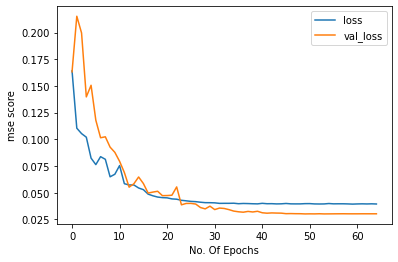

In [46]:
plt.plot(prepared_model_CNNLSTM.history["loss"],label="loss")
plt.plot(prepared_model_CNNLSTM.history["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("No. Of Epochs")
plt.ylabel("mse score")

In [47]:
model_CNNLSTM.evaluate(test_generator, verbose=1)

303/303 [==============================] - 1s 3ms/step - loss: 0.0296


0.029608871787786484

### Get Predictions for new cases

In [48]:
predictions=model_CNNLSTM.predict(test_generator)

pd.DataFrame(predictions)

,0,1,2,3,4
0,15.105814,34.555614,12.738948,89.527809,5.093979
1,13.354726,29.423281,12.433115,95.765839,5.196302
2,13.588117,30.713148,13.829411,99.462227,5.017156
3,12.624731,29.138088,13.497587,97.421494,4.527752
4,9.123182,23.220215,12.099706,94.524391,4.530429
...,...,...,...,...,...
1207,9.674609,24.556751,19.445477,69.882866,3.466104
1208,9.579337,23.998875,19.220165,70.525932,3.497332
1209,9.069198,22.855940,17.343231,72.549004,3.496261
1210,8.354482,19.486975,15.281331,74.509178,3.430735


In [49]:
df_pred=pd.DataFrame(X_test[:,:][win_length:])

rev_trans=scaler.inverse_transform(df_pred)

df_final=dataset[rev_trans.shape[0]*-1:]

df_final[["pm25_pred", "pm10_pred", "no2_pred", "o3_pred", "so2_pred"]]=predictions

df_final

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,pm25,pm10,no2,o3,so2,co,temp,rhum,wspd,pres,...,pm10_AQI,no2_AQI,o3_AQI,so2_AQI,overall_AQI,pm25_pred,pm10_pred,no2_pred,o3_pred,so2_pred
2021-08-12 13:00:00,14.000000,27.200001,15.10,101.333336,4.000000,425.0,32.099998,30.100000,25.799999,1013.900024,...,2.0,1.0,3.0,1.0,3.0,15.105814,34.555614,12.738948,89.527809,5.093979
2021-08-12 14:00:00,13.200000,31.600000,14.30,104.777779,3.666667,425.0,31.600000,30.200001,25.799999,1013.700012,...,2.0,1.0,3.0,1.0,3.0,13.354726,29.423281,12.433115,95.765839,5.196302
2021-08-12 15:00:00,12.000000,29.900000,13.40,101.333336,3.000000,350.0,32.099998,27.000000,25.900000,1014.700012,...,2.0,1.0,3.0,1.0,3.0,13.588117,30.713148,13.829411,99.462227,5.017156
2021-08-12 16:00:00,8.400000,22.500000,13.00,99.444443,3.333333,350.0,30.799999,30.200001,22.100000,1014.599976,...,2.0,1.0,2.0,1.0,2.0,12.624731,29.138088,13.497587,97.421494,4.527752
2021-08-12 17:00:00,6.000000,18.799999,11.40,98.666664,3.000000,300.0,29.700001,33.200001,17.000000,1014.400024,...,1.0,1.0,2.0,1.0,2.0,9.123182,23.220215,12.099706,94.524391,4.530429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01 20:00:00,9.997252,22.843163,22.00,72.000000,2.666667,650.0,18.500000,53.000000,22.200001,1018.400024,...,2.0,1.0,2.0,1.0,2.0,9.674609,24.556751,19.445477,69.882866,3.466104
2021-10-01 21:00:00,9.020690,22.973946,20.75,72.625000,3.000000,700.0,16.900000,57.000000,22.200001,1020.099976,...,2.0,1.0,2.0,1.0,2.0,9.579337,23.998875,19.220165,70.525932,3.497332
2021-10-01 22:00:00,8.760846,19.210289,18.25,73.000000,3.000000,550.0,16.900000,57.599998,21.200001,1019.500000,...,1.0,1.0,2.0,1.0,2.0,9.069198,22.855940,17.343231,72.549004,3.496261
2021-10-01 23:00:00,8.666667,19.375000,19.75,71.875000,3.000000,700.0,16.799999,58.099998,20.200001,1019.000000,...,1.0,1.0,2.0,1.0,2.0,8.354482,19.486975,15.281331,74.509178,3.430735


<AxesSubplot:>

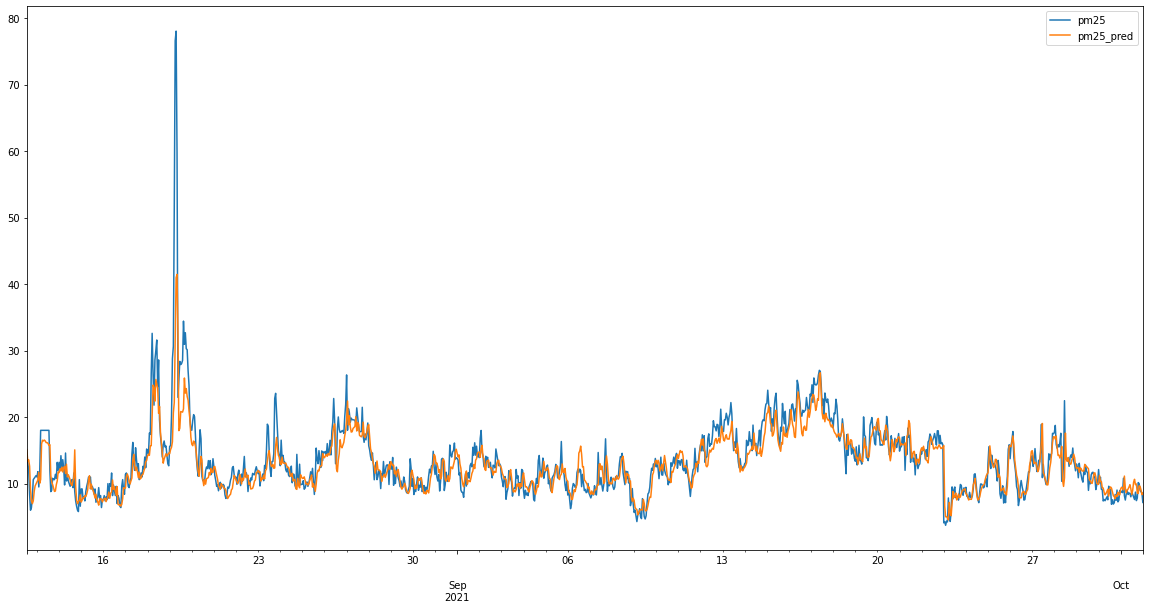

In [50]:
df_final[["pm25","pm25_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

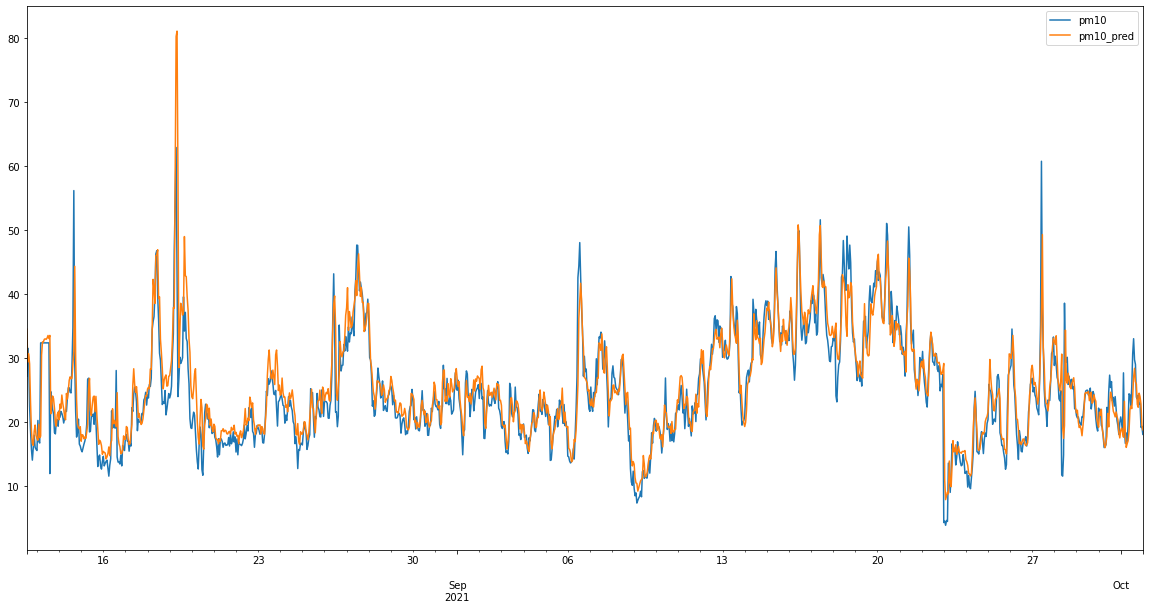

In [51]:
df_final[["pm10","pm10_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

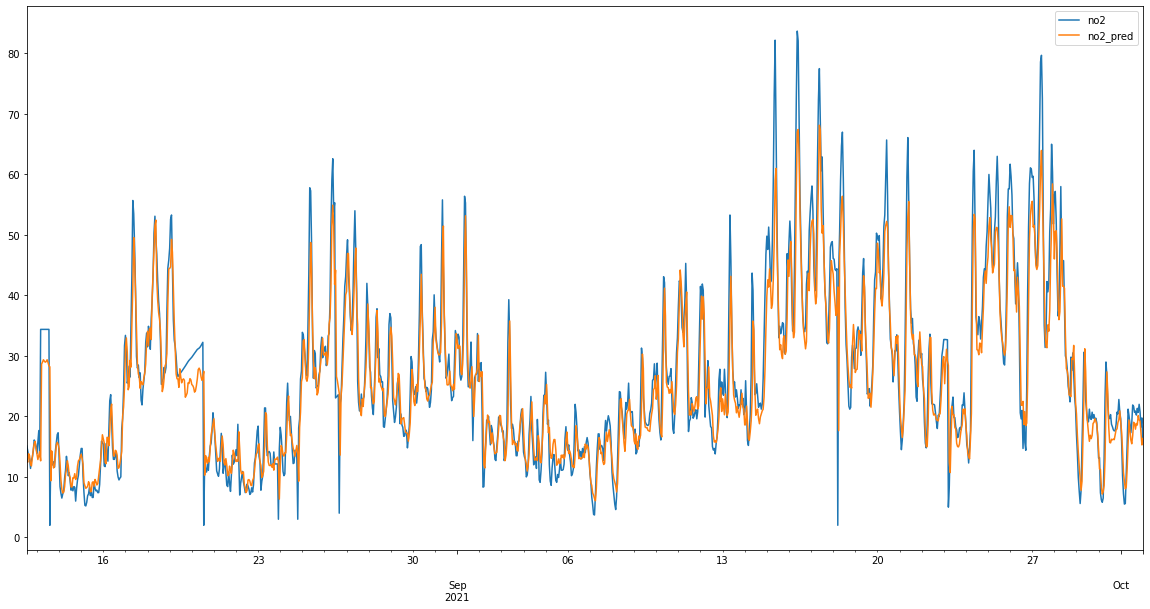

In [52]:
df_final[["no2","no2_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

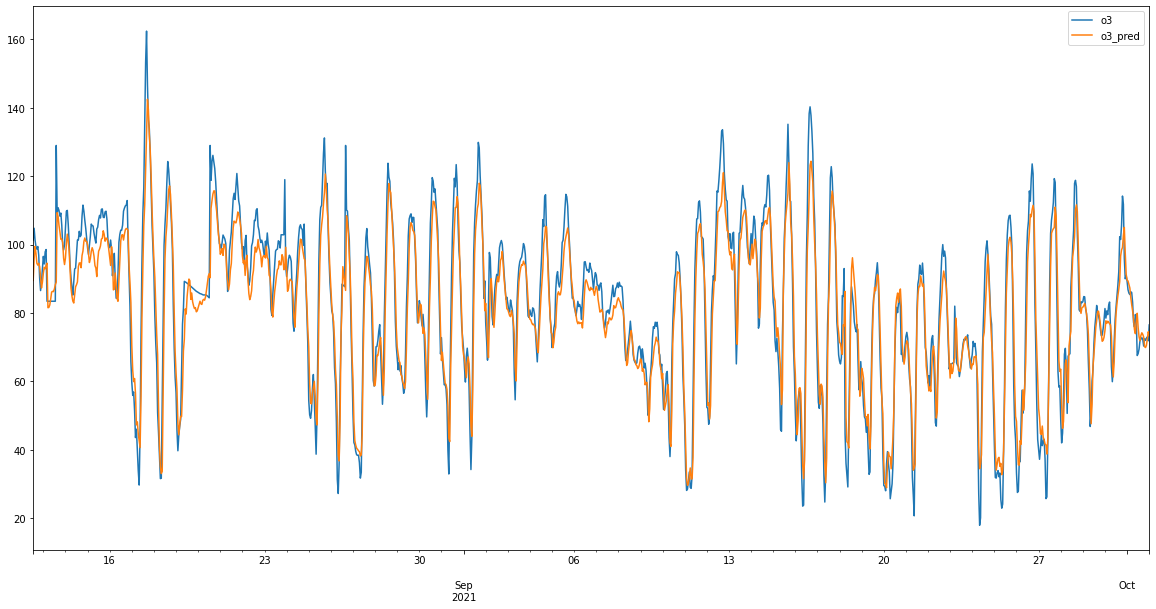

In [53]:
df_final[["o3","o3_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

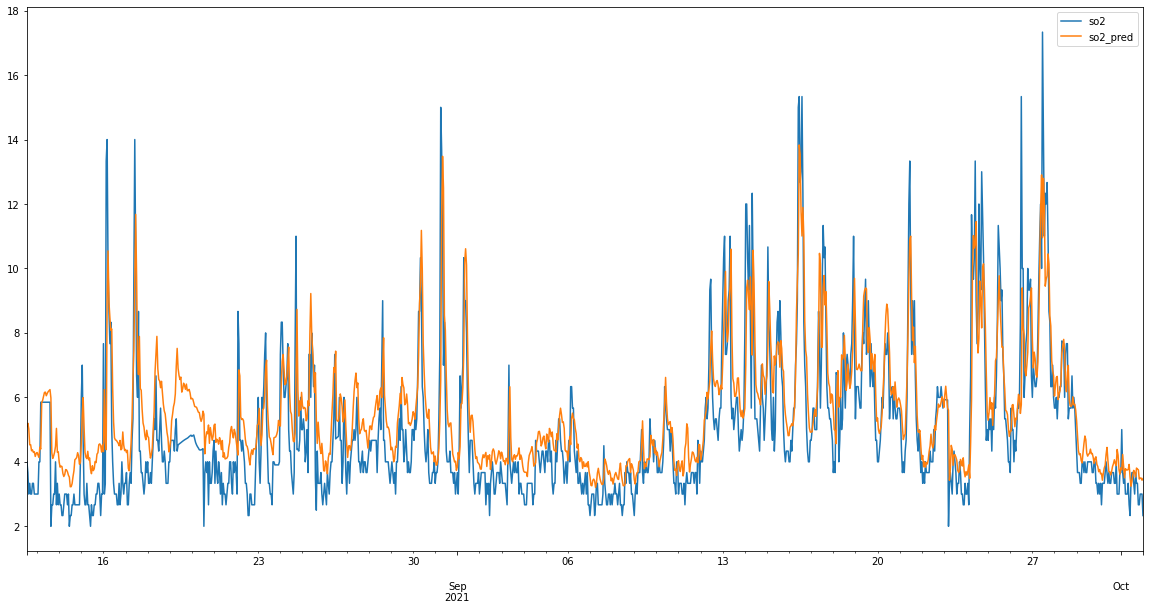

In [54]:
df_final[["so2","so2_pred"]].plot(figsize=(20,10))

In [55]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mslr = tf.keras.metrics.mean_squared_logarithmic_error(y_true, y_pred)
  
    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mslr": mslr.numpy(),
           }

In [56]:
selected_features = ["pm25", "pm10", "no2", "o3", "so2"]

for feature in selected_features:
    print("-----{}-----".format(feature))
    print(evaluate_preds(y_true=df_final[feature].values,
                         y_pred=df_final["{}_pred".format(feature)].values)
         )

-----pm25-----
{'mae': 1.6290026, 'mse': 8.546972, 'rmse': 2.9235206, 'mape': 11.77273, 'mslr': 0.022140378}
-----pm10-----
{'mae': 2.3254695, 'mse': 13.745405, 'rmse': 3.7074797, 'mape': 10.732145, 'mslr': 0.02049915}
-----no2-----
{'mae': 3.334801, 'mse': 24.520641, 'rmse': 4.9518323, 'mape': 18.08071, 'mslr': 0.048445117}
-----o3-----
{'mae': 5.98263, 'mse': 60.030914, 'rmse': 7.747962, 'mape': 8.330592, 'mslr': 0.012653874}
-----so2-----
{'mae': 1.0412711, 'mse': 1.8951335, 'rmse': 1.3766385, 'mape': 23.716837, 'mslr': 0.044305846}
